# Big Data Project (21L-5625,L21-5626,L21-5632)

**Movie and Political Sentiment Analysis with PySpark**

In [1]:
%%bash 
#Installing Pyspark
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317145 sha256=83ae4052984f025147841752d80310a153888e6e34a3a4e15401824593725387
  Stored in directory: /root/.cache/pip/wheels/9f/34/a4/159aa12d0a510d5ff7c8f0220abbea42e5d81ecf588c4fd884
Successfully built pyspark


In [2]:
%%bash

# Download the data files from github
#or one can just run this phython notebook, since I am just linking the sources
data_file_1=imdb_reviews_preprocessed.parquet
data_file_2=sentiments.parquet
data_file_3=tweets.parquet

# If data_file_1 file does not exist in the colab environment
if [[ ! -f ${data_file_1} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_1} 
fi

# If data_file_1 file does not exist in the colab environment
if [[ ! -f ${data_file_2} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_2} 
fi

# If data_file_1 file does not exist in the colab environment
if [[ ! -f ${data_file_3} ]]; then 
   # download the data file from github and save it in this colab environment instance
   wget https://raw.githubusercontent.com/wewilli1/ist718_data/master/${data_file_3} 
fi

--2023-04-24 19:19:31--  https://raw.githubusercontent.com/wewilli1/ist718_data/master/imdb_reviews_preprocessed.parquet
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21597134 (21M) [application/octet-stream]
Saving to: ‘imdb_reviews_preprocessed.parquet’

     0K .......... .......... .......... .......... ..........  0% 8.57M 2s
    50K .......... .......... .......... .......... ..........  0% 8.00M 2s
   100K .......... .......... .......... .......... ..........  0% 42.3M 2s
   150K .......... .......... .......... .......... ..........  0% 45.5M 1s
   200K .......... .......... .......... .......... ..........  1% 12.5M 1s
   250K .......... .......... .......... .......... ..........  1% 52.1M 1s
   300K .......... .......... .......... .......... .

## Loading packages and connecting to Spark cluster

In [3]:
from __future__ import division
from pyspark.sql import SparkSession
from pyspark.ml import feature, regression, evaluation, Pipeline
from pyspark.sql import functions as fn, Row
import matplotlib.pyplot as plt
import glob
import subprocess
import numpy as np
import pandas as pd
import os
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Load sentiment data

In [14]:
sentiments_df =  spark.read.parquet('sentiments.parquet')

In [15]:
sentiments_df.printSchema()

root
 |-- word: string (nullable = true)
 |-- sentiment: long (nullable = true)



In [16]:
sentiments_df.show(5)

+-------------+---------+
|         word|sentiment|
+-------------+---------+
|   gratefully|        1|
|gratification|        1|
|    gratified|        1|
|    gratifies|        1|
|      gratify|        1|
+-------------+---------+
only showing top 5 rows



The schema is very simple: for each word, we have whether it is positive (+1) or negative (-1)

In [17]:
# a sample of positive words
sentiments_df.where(fn.col('sentiment') == 1).show(5)

+-------------+---------+
|         word|sentiment|
+-------------+---------+
|   gratefully|        1|
|gratification|        1|
|    gratified|        1|
|    gratifies|        1|
|      gratify|        1|
+-------------+---------+
only showing top 5 rows



In [18]:
# a sample of negative words
sentiments_df.where(fn.col('sentiment') == -1).show(5)

+----------+---------+
|      word|sentiment|
+----------+---------+
|   2-faced|       -1|
|   2-faces|       -1|
|  abnormal|       -1|
|   abolish|       -1|
|abominable|       -1|
+----------+---------+
only showing top 5 rows



#Lets see how many of each category we have

In [19]:
sentiments_df.groupBy('sentiment').agg(fn.count('*')).show()

+---------+--------+
|sentiment|count(1)|
+---------+--------+
|        1|    2006|
|       -1|    4783|
+---------+--------+



We have almost two times the number of negative words!

To test our approach, we will use a sample of [IMDB](http://www.imdb.com/) reviews that were tagged as positive and negative.

Let's load them:

In [20]:
imdb_reviews_df = spark.read.parquet('imdb_reviews_preprocessed.parquet')
imdb_reviews_df.show(10)

+---------+--------------------+-----+
|       id|              review|score|
+---------+--------------------+-----+
|pos_10006|In this "critical...|  1.0|
|pos_10013|Like one of the p...|  1.0|
|pos_10022|Aro Tolbukhin bur...|  1.0|
|pos_10033|The movie Titanic...|  1.0|
| pos_1003|Another Aussie ma...|  1.0|
| pos_1004|After a brief pro...|  1.0|
|pos_10053|I must admit, whe...|  1.0|
|pos_10062|Wow. What a wonde...|  1.0|
|pos_10074|quote by Nicolas ...|  1.0|
|pos_10083|The fact that thi...|  1.0|
+---------+--------------------+-----+
only showing top 10 rows



The schema is very simple: for each word, we have whether it is positive (+1) or negative (-1)

Print the unique scores in the imdb_reviews_df.  A positive review has a score of 1, and a negative review has a score of 0.

In [21]:
imdb_reviews_df.toPandas()['score'].unique()

array([1., 0.])

Let's take a look at a positive review

In [22]:
imdb_reviews_df.where(fn.col('score') == 1).first()

Row(id='pos_10006', review='In this "critically acclaimed psychological thriller based on true events, Gabriel (Robin Williams), a celebrated writer and late-night talk show host, becomes captivated by the harrowing story of a young listener and his adoptive mother (Toni Collette). When troubling questions arise about this boy\'s (story), however, Gabriel finds himself drawn into a widening mystery that hides a deadly secret\x85" according to film\'s official synopsis.<br /><br />You really should STOP reading these comments, and watch the film NOW...<br /><br />The "How did he lose his leg?" ending, with Ms. Collette planning her new life, should be chopped off, and sent to "deleted scenes" land. It\'s overkill. The true nature of her physical and mental ailments should be obvious, by the time Mr. Williams returns to New York. Possibly, her blindness could be in question - but a revelation could have be made certain in either the "highway" or "video tape" scenes. The film would benefi

And a negative one

In [23]:
imdb_reviews_df.where(fn.col('score') == 0).first()

Row(id='neg_10006', review="I don't know who to blame, the timid writers or the clueless director. It seemed to be one of those movies where so much was paid to the stars (Angie, Charlie, Denise, Rosanna and Jon) that there wasn't enough left to really make a movie. This could have been very entertaining, but there was a veil of timidity, even cowardice, that hung over each scene. Since it got an R rating anyway why was the ubiquitous bubble bath scene shot with a 70-year-old woman and not Angie Harmon? Why does Sheen sleepwalk through potentially hot relationships WITH TWO OF THE MOST BEAUTIFUL AND SEXY ACTRESSES in the world? If they were only looking for laughs why not cast Whoopi Goldberg and Judy Tenuta instead? This was so predictable I was surprised to find that the director wasn't a five year old. What a waste, not just for the viewers but for the actors as well.", score=0.0)

The first problem that we encounter is that the reviews are in plain text. We need to split the words and then match them to `sentiment_df`.  To do this, we will use a transformation that takes raw text and outputs a list of words

In [24]:
from pyspark.ml.feature import RegexTokenizer

`RegexTokenizer` extracts a sequence of matches from the input text. Regular expressions are a powerful tool to extract strings with certain characteristics.  The pattern `\p{L}+` means that it will extract letters without accents (e.g., it will extract "Acuna" from "Acuña"). `setGaps=False` means that it will keep applying the rule until it can't extract new words. You have to set the input column from the incoming dataframe (in our case the `review` column) and the new column that will be added (e.g., `words`).

In [25]:
tokenizer = RegexTokenizer().setGaps(False)\
  .setPattern("\\p{L}+")\
  .setInputCol("review")\
  .setOutputCol("words")

In [26]:
review_words_df = tokenizer.transform(imdb_reviews_df)
print(review_words_df)

DataFrame[id: string, review: string, score: double, words: array<string>]


Applying the transformation doesn't actually do anything until you apply an action. But as you can see, a new column `words` of type `array` of `string` was added by the transformation. We can see how it looks:

In [27]:
review_words_df.show(5)

+---------+--------------------+-----+--------------------+
|       id|              review|score|               words|
+---------+--------------------+-----+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|
+---------+--------------------+-----+--------------------+
only showing top 5 rows



Now, we want to match every word from `sentiment_df` in the array `words` shown before. One way of doing this is to _explode_ the column `words` to create a row for each element in that list. Then, we would join that result with the dataframe `sentiment` to continue further.

In [28]:
review_words_df.select('id', fn.explode('words').alias('word1')).show(5)

+---------+-------------+
|       id|        word1|
+---------+-------------+
|pos_10006|           in|
|pos_10006|         this|
|pos_10006|   critically|
|pos_10006|    acclaimed|
|pos_10006|psychological|
+---------+-------------+
only showing top 5 rows



Now if we join that with sentiment, we can see if there are positive and negative words in each review:

In [30]:
review_word_sentiment_df = review_words_df.\
    select('id', fn.explode('words').alias('word')).\
    join(sentiments_df, 'word')
review_word_sentiment_df.show(5)

+----------+---------+---------+
|      word|       id|sentiment|
+----------+---------+---------+
| acclaimed|pos_10006|        1|
|celebrated|pos_10006|        1|
| troubling|pos_10006|       -1|
|   mystery|pos_10006|       -1|
|    deadly|pos_10006|       -1|
+----------+---------+---------+
only showing top 5 rows



Check the unique sentiment column values.  Sentiments should be +1 and -1 for positive and negative word sentiments respectively.

In [31]:
review_word_sentiment_df.groupBy("sentiment").count().show()

+---------+------+
|sentiment| count|
+---------+------+
|        1|257274|
|       -1|241972|
+---------+------+



Now we can simply average the sentiment per review id and, say, pick positive when the average is above 0, and negative otherwise.

In [32]:
simple_sentiment_prediction_df = review_word_sentiment_df.\
    groupBy('id').\
    agg(fn.avg('sentiment').alias('avg_sentiment')).\
    withColumn('predicted', fn.when(fn.col('avg_sentiment') > 0, 1.0).otherwise(0.))
simple_sentiment_prediction_df.show(5)

+---------+--------------------+---------+
|       id|       avg_sentiment|predicted|
+---------+--------------------+---------+
|pos_10149| 0.42857142857142855|      1.0|
|pos_10377|  0.5384615384615384|      1.0|
| pos_1299| 0.09090909090909091|      1.0|
| pos_2228|-0.14285714285714285|      0.0|
| pos_5052|  0.7777777777777778|      1.0|
+---------+--------------------+---------+
only showing top 5 rows



Now, lets compute the accuracy of our prediction

In [33]:
imdb_reviews_df.\
    join(simple_sentiment_prediction_df, 'id').\
    select(fn.expr('float(score == predicted)').alias('correct')).\
    select(fn.avg('correct')).\
    show()

+-----------------+
|     avg(correct)|
+-----------------+
|0.732231471106131|
+-----------------+



## A data-driven sentiment prediction

First, we need to create a sequence to take from raw text to term frequency. This is necessary because we don't know the number of tokens in the text and therefore we need to _estimate_ such quantity from the data.

In [34]:
# we obtain the stop words from a website
import requests
stop_words = requests.get('http://ir.dcs.gla.ac.uk/resources/linguistic_utils/stop_words').text.split()
stop_words[0:10]

['a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost']

In [35]:
from pyspark.ml.feature import StopWordsRemover
sw_filter = StopWordsRemover()\
  .setStopWords(stop_words)\
  .setCaseSensitive(False)\
  .setInputCol("words")\
  .setOutputCol("filtered")

Count Vectorizer

In [36]:
from pyspark.ml.feature import CountVectorizer

# we will remove words that appear in 5 docs or less
cv = CountVectorizer(minTF=1., minDF=5., vocabSize=2**17)\
  .setInputCol("filtered")\
  .setOutputCol("tf")

In [37]:
# we now create a pipelined transformer
cv_pipeline = Pipeline(stages=[tokenizer, sw_filter, cv]).fit(imdb_reviews_df)

In [38]:
# now we can make the transformation between the raw text and the counts
cv_pipeline.transform(imdb_reviews_df).show(5)

+---------+--------------------+-----+--------------------+--------------------+--------------------+
|       id|              review|score|               words|            filtered|                  tf|
+---------+--------------------+-----+--------------------+--------------------+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|[critically, accl...|(26677,[0,1,3,4,5...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|[like, previous, ...|(26677,[1,2,3,4,5...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|[aro, tolbukhin, ...|(26677,[0,1,2,12,...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|[movie, titanic, ...|(26677,[0,1,2,3,4...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|[aussie, masterpi...|(26677,[4,5,9,24,...|
+---------+--------------------+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



The term frequency vector is represented with a sparse vector. We have 26,677 terms.

In [39]:
len(cv_pipeline.stages[-1].vocabulary)

26677

Finally, we build another pipeline that takes the output of the previous pipeline and _lowers_ the terms of documents that are very common.

In [40]:
from pyspark.ml.feature import IDF
idf = IDF().\
    setInputCol('tf').\
    setOutputCol('tfidf')

In [41]:
idf_pipeline = Pipeline(stages=[cv_pipeline, idf]).fit(imdb_reviews_df)

In [42]:
idf_pipeline.transform(imdb_reviews_df).select('tfidf').show(1, False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Therefore, the `idf_pipeline` takes the raw text from the datafarme `imdb_reviews_df` and creates a feature vector called `tfidf`!

In [43]:
tfidf_df = idf_pipeline.transform(imdb_reviews_df)
print("tfidf_df shape: ", tfidf_df.count(), len(tfidf_df.columns))

tfidf_df shape:  25000 7


In [44]:
tfidf_df.show(5)

+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|       id|              review|score|               words|            filtered|                  tf|               tfidf|
+---------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|pos_10006|In this "critical...|  1.0|[in, this, critic...|[critically, accl...|(26677,[0,1,3,4,5...|(26677,[0,1,3,4,5...|
|pos_10013|Like one of the p...|  1.0|[like, one, of, t...|[like, previous, ...|(26677,[1,2,3,4,5...|(26677,[1,2,3,4,5...|
|pos_10022|Aro Tolbukhin bur...|  1.0|[aro, tolbukhin, ...|[aro, tolbukhin, ...|(26677,[0,1,2,12,...|(26677,[0,1,2,12,...|
|pos_10033|The movie Titanic...|  1.0|[the, movie, tita...|[movie, titanic, ...|(26677,[0,1,2,3,4...|(26677,[0,1,2,3,4...|
| pos_1003|Another Aussie ma...|  1.0|[another, aussie,...|[aussie, masterpi...|(26677,[4,5,9,24,...|(26677,[4,5,9,24,...|
+---------+-----

The cell below prints out the 'tf' and 'tfidf' columns for the first 10 rows of the tfidf_df.  Note that the tfidf column is transformed to account for the frequency with which the word appears in the corpus.  Words that appear more often are penalized more than words that do not appear as frequently in the corpus.

In [45]:
tfidf_df.limit(10).toPandas().loc[:10, ['tf', 'tfidf']]

,tf,tfidf
0,"(12.0, 5.0, 0.0, 3.0, 1.0, 1.0, 0.0, 1.0, 1.0,...","(6.399789021643247, 1.5355439272599614, 0.0, 1..."
1,"(0.0, 2.0, 4.0, 1.0, 1.0, 3.0, 3.0, 0.0, 0.0, ...","(0.0, 0.6142175709039845, 1.9611159574304948, ..."
2,"(6.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(3.1998945108216237, 0.6142175709039845, 0.490..."
3,"(6.0, 1.0, 3.0, 7.0, 3.0, 2.0, 1.0, 0.0, 2.0, ...","(3.1998945108216237, 0.30710878545199227, 1.47..."
4,"(0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.5028974533168351, 0.761..."
5,"(14.0, 7.0, 1.0, 6.0, 2.0, 0.0, 2.0, 3.0, 1.0,...","(7.466420525250455, 2.149761498163946, 0.49027..."
6,"(6.0, 2.0, 3.0, 1.0, 2.0, 1.0, 0.0, 0.0, 1.0, ...","(3.1998945108216237, 0.6142175709039845, 1.470..."
7,"(6.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(3.1998945108216237, 0.0, 0.0, 1.1677330317010..."
8,"(4.0, 0.0, 0.0, 4.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(2.1332630072144156, 0.0, 0.0, 2.3354660634020..."
9,"(6.0, 1.0, 0.0, 2.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","(3.1998945108216237, 0.30710878545199227, 0.0,..."


# Data science pipeline for estimating sentiments

First, let's split the data into training, validation, and testing.

In [46]:
training_df, validation_df, testing_df = imdb_reviews_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [47]:
training_df.limit(5).toPandas()

,id,review,score
0,neg_1,Robert DeNiro plays the most unbelievably inte...,0.0
1,neg_10,"This film had a lot of promise, and the plot w...",0.0
2,neg_100,OK its not the best film I've ever seen but at...,0.0
3,neg_10000,Airport '77 starts as a brand new luxury 747 p...,0.0
4,neg_10001,This film lacked something I couldn't put my f...,0.0


In [48]:
[training_df.count(), validation_df.count(), testing_df.count()]

[14962, 7531, 2507]

Logistic Regression

In [49]:
from pyspark.ml.classification import LogisticRegression

In [50]:
lr = LogisticRegression().\
    setLabelCol('score').\
    setFeaturesCol('tfidf').\
    setRegParam(0.0).\
    setMaxIter(100).\
    setElasticNetParam(0.)

Lets create a pipeline transformation by chaining the `idf_pipeline` with the logistic regression step (`lr`)

In [51]:
lr_pipeline = Pipeline(stages=[idf_pipeline, lr]).fit(training_df)

The next cell defines a class capable of calculating ROC and PR curves.  The following cell creates a ROC curve using transformed data from the pipeline above.

In [52]:
# see https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
from pyspark.mllib.evaluation import BinaryClassificationMetrics

# Scala version implements .roc() and .pr()
# Python: https://spark.apache.org/docs/latest/api/python/_modules/pyspark/mllib/common.html
# Scala: https://spark.apache.org/docs/latest/api/java/org/apache/spark/mllib/evaluation/BinaryClassificationMetrics.html
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        
        for row in rdd.collect():
            
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)

/usr/local/lib/python3.9/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


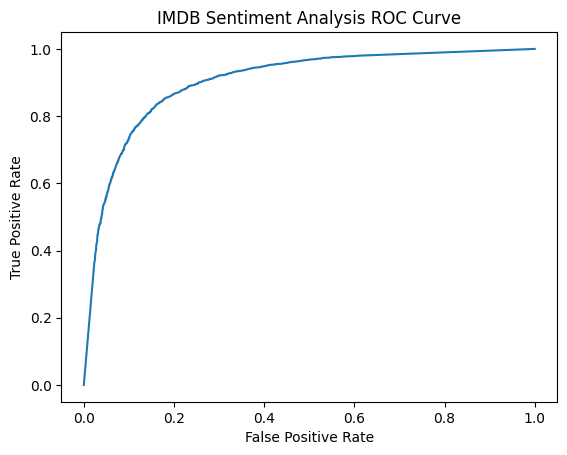

In [53]:
import matplotlib.pyplot as plt

# Create a Pipeline estimator and fit on train DF, predict on test DF
predictions = lr_pipeline.transform(validation_df)

# Returns as a list (false positive rate, true positive rate)
preds = predictions.select('score','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['score'])))
points = CurveMetrics(preds).get_curve('roc')

plt.figure()
x_val = [x[0] for x in points]
y_val = [x[1] for x in points]
plt.title('IMDB Sentiment Analysis ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.plot(x_val, y_val)

Lets estimate the accuracy:

In [54]:
lr_pipeline.transform(validation_df).\
    select(fn.expr('float(prediction = score)').alias('correct')).\
    select(fn.avg('correct')).show()

+------------------+
|      avg(correct)|
+------------------+
|0.8360111538972248|
+------------------+



The performance is much better than before.

The problem however is that we are overfitting because we have many features compared to the training examples:

For example, if we look at the weights of the features, there is a lot of noise:

In [55]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[-1].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
print("num weights:", len(weights))
print("num rows:", validation_df.count())

coeffs_df = pd.DataFrame({'word': vocabulary, 'weight': weights})
coeffs_df.head()

num weights: 26677
num rows: 7531


,word,weight
0,br,-0.105915
1,s,0.181536
2,movie,-0.336467
3,film,0.194032
4,t,-0.783280


The most negative words are:

In [56]:
coeffs_df.sort_values('weight').head(5)

,word,weight
23304,zoolander,-6.642286
21131,grossness,-6.096098
26293,residue,-5.677060
23883,publicize,-5.493201
23282,dodgeball,-5.350357


And the most positive:

In [57]:
coeffs_df.sort_values('weight', ascending=False).head(5)

,word,weight
20792,choco,7.881534
26406,silhouetted,7.406967
26318,eliciting,6.151619
21679,praiseworthy,6.142447
13496,shrewd,5.979843


But none of them make sense. What is happening? We are overfitting the data. Those words that don't make sense are capturing just noise in the reviews.

## Spark allows us to fit elastic net regularization easily

In [58]:
lambda_par = 0.02
alpha_par = 0.3
en_lr = LogisticRegression().\
        setLabelCol('score').\
        setFeaturesCol('tfidf').\
        setRegParam(lambda_par).\
        setMaxIter(100).\
        setElasticNetParam(alpha_par)

And we define a new Pipeline with all steps combined

In [59]:
en_lr_estimator = Pipeline(stages=[tokenizer, sw_filter, cv, idf, en_lr])

In [60]:
en_lr_pipeline = en_lr_estimator.fit(training_df)

Let's look at the performance

In [61]:
en_lr_pipeline.transform(validation_df).select(fn.avg(fn.expr('float(prediction = score)'))).show()

+-------------------------+
|avg((prediction = score))|
+-------------------------+
|       0.8688089231177798|
+-------------------------+



We improve performance slightly, but whats more important is that we improve the understanding of the word sentiments. Lets look at the weights:

In [62]:
en_weights = en_lr_pipeline.stages[-1].coefficients.toArray()
en_coeffs_df = pd.DataFrame({'word': en_lr_pipeline.stages[2].vocabulary, 'weight': en_weights})

The most negative words all make sense ("worst" is _actually_ more negative than than "worse")!

In [63]:
en_coeffs_df.sort_values('weight').head(15)

,word,weight
105,worst,-0.369188
262,waste,-0.334131
190,awful,-0.259531
12,bad,-0.238970
606,poorly,-0.185563
522,dull,-0.185538
1109,disappointment,-0.181951
184,boring,-0.180375
179,poor,-0.177850
243,worse,-0.173731


Same thing with positive words

In [64]:
en_coeffs_df.sort_values('weight', ascending=False).head(15)

,word,weight
13,great,0.283820
161,excellent,0.240269
221,wonderful,0.200133
26,best,0.168678
300,favorite,0.161667
227,perfect,0.157898
286,amazing,0.142479
889,incredible,0.139636
270,loved,0.133010
2047,refreshing,0.129359


Are there words with _literarily_ zero importance for predicting sentiment? Yes, and most of them!

In [65]:
en_coeffs_df.query('weight == 0.0').shape

(19609, 2)

In fact, approximately 95% of features are not needed to achieve a __better__ performance than all previous models!

In [66]:
en_coeffs_df.query('weight == 0.0').shape[0]/en_coeffs_df.shape[0]

0.9502786527744124

Let's look at these _neutral_ words

In [67]:
en_coeffs_df.query('weight == 0.0').head(15)

,word,weight
0,br,0.0
3,film,0.0
5,like,0.0
9,story,0.0
10,really,0.0
11,people,0.0
14,don,0.0
15,way,0.0
17,movies,0.0
18,think,0.0


But, did we choose the right $\lambda$ and $\alpha$ parameters? We should run an experiment where we try different combinations of them. Fortunately, Spark let us do this by using a grid - a method that generates combination of parameters.

In [68]:
from pyspark.ml.tuning import ParamGridBuilder

We need to build a new estimator pipeline

In [69]:
en_lr_estimator.getStages()

[RegexTokenizer_18e623850b1a,
 StopWordsRemover_49bcf0e3b650,
 CountVectorizer_789893e3001b,
 IDF_507b4bb23612,
 LogisticRegression_b427af0d8b7f]

In [70]:
grid = ParamGridBuilder().\
    addGrid(en_lr.regParam, [0., 0.01, 0.02]).\
    addGrid(en_lr.elasticNetParam, [0., 0.2, 0.4]).\
    build()

This is the list of parameters that we will try:

In [71]:
grid

[{Param(parent='LogisticRegression_b427af0d8b7f', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_b427af0d8b7f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
 {Param(parent='LogisticRegression_b427af0d8b7f', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_b427af0d8b7f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2},
 {Param(parent='LogisticRegression_b427af0d8b7f', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
  Param(parent='LogisticRegression_b427af0d8b7f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.4},
 {Pa

In [72]:
all_models = []
for j in range(len(grid)):
    print("Fitting model {}".format(j+1))
    model = en_lr_estimator.fit(training_df, grid[j])
    all_models.append(model)

Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8
Fitting model 9


In [73]:
# estimate the accuracy of each of them:
accuracies = [m.\
    transform(validation_df).\
    select(fn.avg(fn.expr('float(score = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in all_models]

In [74]:
accuracies

[0.8389324126941973,
 0.8389324126941973,
 0.8389324126941973,
 0.8633647589961493,
 0.8794316823794981,
 0.8729252423316957,
 0.8678794316823795,
 0.8761120701102111,
 0.8600451467268623]

In [75]:
import numpy as np

In [76]:
best_model_idx = np.argmax(accuracies)
print("best model index =", best_model_idx)

best model index = 4


So the best model we found has the following parameters

In [77]:
grid[best_model_idx]

{Param(parent='LogisticRegression_b427af0d8b7f', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
 Param(parent='LogisticRegression_b427af0d8b7f', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.2}

In [78]:
best_model = all_models[best_model_idx]

In [79]:
accuracies[best_model_idx]

0.8794316823794981

In [80]:
# estimate generalization performance
best_model.\
    transform(testing_df).\
    select(fn.avg(fn.expr('float(score = prediction)')).alias('accuracy')).\
    show()

+------------------+
|          accuracy|
+------------------+
|0.8687674511368169|
+------------------+



## Finally, predicting tweet sentiments

Now we can use this model to predict sentiments on Twitter

In [81]:
tweets_df = spark.read.parquet('tweets.parquet')

We have 1K tweets from each candidate

In [82]:
tweets_df.groupby('handle').agg(fn.count('*')).show()

+----------------+--------+
|          handle|count(1)|
+----------------+--------+
| @HillaryClinton|    1000|
|@realDonaldTrump|    1000|
+----------------+--------+



We can now predict the sentiment of the Tweet using our best model, we need to rename the column so that it matches our previous pipeline (`review` => ...)

In [83]:
best_model.transform(tweets_df.withColumnRenamed('text', 'review')).select('handle', 'review', 'prediction').show()

+---------------+--------------------+----------+
|         handle|              review|prediction|
+---------------+--------------------+----------+
|@HillaryClinton|RT @ZekeJMiller: ...|       1.0|
|@HillaryClinton|“She’s just out t...|       1.0|
|@HillaryClinton|We're going to ma...|       0.0|
|@HillaryClinton|Don't boo. Vote! ...|       0.0|
|@HillaryClinton|This Republican d...|       0.0|
|@HillaryClinton|Hillary teamed up...|       1.0|
|@HillaryClinton|RT @mayaharris_: ...|       1.0|
|@HillaryClinton|"It was overwhelm...|       1.0|
|@HillaryClinton|Great step forwar...|       1.0|
|@HillaryClinton|"I feel like I'm ...|       1.0|
|@HillaryClinton|Nobody here was “...|       1.0|
|@HillaryClinton|For those few peo...|       0.0|
|@HillaryClinton|Remember, don't b...|       1.0|
|@HillaryClinton|Too many talented...|       1.0|
|@HillaryClinton|There are hundred...|       0.0|
|@HillaryClinton|It's 3:20am. As g...|       1.0|
|@HillaryClinton|Trump stood on a ...|       0.0|


Now, lets summarize our results in a graph!

In [84]:
%matplotlib inline

In [85]:
import seaborn

In [86]:
sentiment_pd = best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    groupby('handle').\
    agg(fn.avg('prediction').alias('ave_prediction'), (2*fn.stddev('prediction')/fn.sqrt(fn.count('*'))).alias('std_err')).\
    toPandas()

In [87]:
sentiment_pd.head()

,handle,ave_prediction,std_err
0,@HillaryClinton,0.571,0.031318
1,@realDonaldTrump,0.702,0.028942


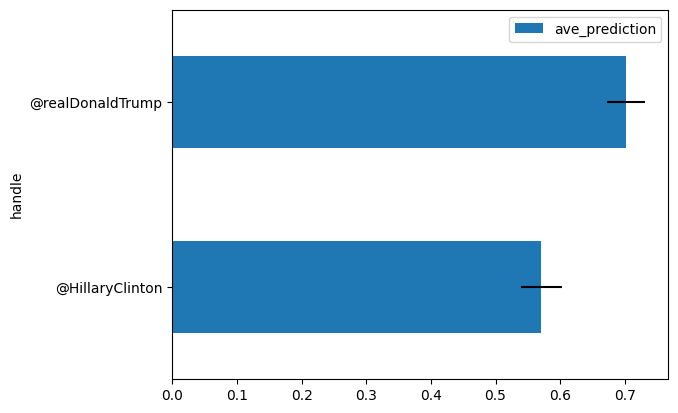

In [88]:
sentiment_pd.plot(x='handle', y='ave_prediction', xerr='std_err', kind='barh');

But let's examine some "negative" tweets by Trump

In [89]:
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@realDonaldTrump').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review='Moderator: Hillary paid $225,000 by a Brazilian bank for a speech that called for “open borders.” That’s a quote! #Debate #BigLeagueTruth'),
 Row(review='TRUMP &amp; CLINTON ON IMMIGRATION\n#Debate #BigLeagueTruth https://t.co/OP4c7Jc8Ad'),
 Row(review='Hillary is too weak to lead on border security-no solutions, no ideas, no credibility.She supported NAFTA, worst deal in US history. #Debate'),
 Row(review='One of my first acts as President will be to deport the drug lords and then secure the border. #Debate #MAGA'),
 Row(review='Hillary Clinton will use American tax dollars to provide amnesty for thousands of illegals. I will put… https://t.co/ZpV33TfbR6')]

And Clinton

In [90]:
best_model.\
    transform(tweets_df.withColumnRenamed('text', 'review')).\
    where(fn.col('handle') == '@HillaryClinton').\
    where(fn.col('prediction') == 0).\
    select('review').\
    take(5)

[Row(review="We're going to make college debt-free for everyone in America. See how much you could save with Hillary's plan at… https://t.co/Fhzkubhpj7"),
 Row(review="Don't boo. Vote! https://t.co/tTgeqy51PU https://t.co/9un3FUVxoG"),
 Row(review='This Republican dad is struggling with the idea of his daughter growing up in a country led by Donald Trump. https://t.co/Tn3rQqJJKp'),
 Row(review="For those few people knocking public service, hope you'll reconsider answering the call to help others. Because we're stronger together."),
 Row(review="There are hundreds of thousands more @AmeriCorps applications than spots. Horrible! Let's expand it from 75,000 annual members to 250,000.")]

In [91]:
from pyspark.ml import feature

In [92]:
from pyspark.sql import types

def probability_positive(probability_column):
    return float(probability_column[1])
func_probability_positive = fn.udf(probability_positive, types.DoubleType())

prediction_probability_df = best_model.transform(validation_df).\
    withColumn('probability_positive', func_probability_positive('probability')).\
    select('id', 'review', 'score', 'probability_positive')
prediction_probability_df.show()

+---------+--------------------+-----+--------------------+
|       id|              review|score|probability_positive|
+---------+--------------------+-----+--------------------+
|    neg_0|Story of a man wh...|  0.0|  0.4858256123045229|
| neg_1000|The plot for Desc...|  0.0| 0.23773092718405964|
|neg_10003|When I was little...|  0.0|6.864567527598009E-4|
|neg_10006|I don't know who ...|  0.0| 0.08939747035805656|
|neg_10012|This movie must b...|  0.0| 0.00807233188176526|
|neg_10014|I saw this movie ...|  0.0| 0.45210546440878807|
|neg_10019|Kareena Kapoor in...|  0.0|4.943247978200782E-4|
|neg_10022|Summer season is ...|  0.0|  0.6559859138052624|
|neg_10023|Shame on Yash Raj...|  0.0|2.732321286786909...|
|neg_10024|First lesson that...|  0.0| 0.03837454919442762|
|neg_10026|I had some expect...|  0.0|   0.567648231964684|
| neg_1003|OK, I am not Japa...|  0.0| 0.16001109982402284|
|neg_10033|I was very disple...|  0.0|  0.3506335602422507|
|neg_10034|If there is one f...|  0.0|2.